# Sistema de Recomendação de Moda usando Recursos de Imagem

Um sistema de recomendação de moda que usa recursos de imagem aproveita a visão computacional e técnicas de aprendizado de máquina para analisar os aspectos visuais dos itens de moda (como cor, textura e estilo) e recomendar produtos semelhantes ou complementares aos usuários.

**Instalando a biblioteca tensorflow**

In [33]:
! pip install tensorflow

In [34]:
from zipfile import ZipFile
import os

In [35]:
CAMINHO_ZIP_FILE = "women-fashion.zip"
DIRETORIO_EXTRAIDO = "./women_fashion/"

In [36]:
if not os.path.exists(DIRETORIO_EXTRAIDO):
    os.mkdir(DIRETORIO_EXTRAIDO)

with ZipFile(CAMINHO_ZIP_FILE, 'r') as zipObj:
    zipObj.extractall(DIRETORIO_EXTRAIDO)

arquivos_extraidos = os.listdir(DIRETORIO_EXTRAIDO)
print(arquivos_extraidos[:10])

['women fashion', '__MACOSX']


Listar o contéudo para entender os tipos e números de imagens do diretório *"women fashion"* que nós temos.

In [37]:
# Corrigindo o caminho para incluir o diretório "women fashion" e listar seu conteúdo
DIRETORIO_EXTRAIDO_ATUALIZADO = os.path.join(DIRETORIO_EXTRAIDO, "women fashion")

In [38]:
# Listar os arquivos do diretório atualizado
arquivos_extraidos_atualizados = os.listdir(DIRETORIO_EXTRAIDO_ATUALIZADO)
arquivos_extraidos_atualizados[:10], len(arquivos_extraidos_atualizados)

(['.DS_Store',
  'anarkali suit with a long, olive green kurta adorned with intricate embroidery around the neckline and cuffs, paired with matching fitted trousers.jpg',
  'Anarkali suit with a modern twist.jpg',
  'Anarkali suit with fitted bodice with a high neckline.jpg',
  'anarkali suit with intricate silver embellishments on the neckline, sleeves.jpg',
  'anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg',
  'anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg',
  'glamorous two-piece outfit featuring a sequined design.jpeg',
  'green dress with a floral pattern, paired with matching green trousers.jpg',
  'high-waisted white trousers paired with a structured, corset-style bodice featuring mesh.jpg'],
 97)

**A primeira imagem do conjunto de dados**

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# Função para carregar e mostrar uma imagem
def display_image(caminho_arquivo):
    imagem = Image.open(caminho_arquivo)
    plt.imshow(imagem)
    plt.axis('off')
    plt.show()

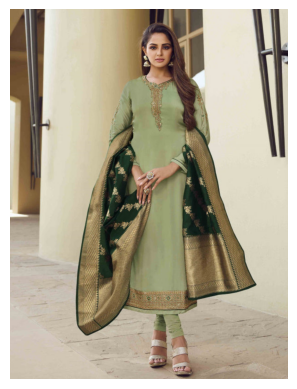

In [41]:
# Demonstrar a primeira imagem para ver suas características
caminho_primeira_imagem = os.path.join(DIRETORIO_EXTRAIDO_ATUALIZADO,
                                       arquivos_extraidos_atualizados[1])
display_image(caminho_primeira_imagem)

Listar de todos os caminhos de arquivos de imagem que serão usados ​​posteriormente na extração dos recursos de cada imagem no conjunto de dados

In [42]:
import glob

# Caminho do diretório que contém suas imagens
diretorio_imagem = "./women_fashion/women fashion"

lista_caminho_imagem = [arquivo for arquivo in glob.glob(os.path.join(
                        diretorio_imagem, '*.*')) if arquivo.endswith(('.jpg',
                                                                       '.png',
                                                                       '.jpeg',
                                                                       '.webp'))
                        ]

O módulo *glob* é usado para gerar uma lista de caminhos de arquivos para imagens armazenadas no diretório.  A função *glob.glob* procura arquivos que correspondam a um padrão especificado, neste caso, \*.\*, que corresponde a todos os arquivos no diretório. A compreensão da lista filtra esses arquivos para incluir apenas aqueles com extensões de arquivo de imagem específicas (*.jpg, .png, .jpeg, .webp*).

In [43]:
# Imprimir a lista de caminhos de arquivos de imagem
print(lista_caminho_imagem)

['./women_fashion/women fashion/anarkali suit with a long, olive green kurta adorned with intricate embroidery around the neckline and cuffs, paired with matching fitted trousers.jpg', './women_fashion/women fashion/Anarkali suit with a modern twist.jpg', './women_fashion/women fashion/Anarkali suit with fitted bodice with a high neckline.jpg', './women_fashion/women fashion/anarkali suit with intricate silver embellishments on the neckline, sleeves.jpg', './women_fashion/women fashion/anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg', './women_fashion/women fashion/anarkali suit. It consists of a turquoise skirt with detailed golden embroidery, a multicolored blouse with floral patterns, and an orange dupatta with lace borders.jpg', './women_fashion/women fashion/glamorous two-piece outfit featuring a sequined design.jpeg', './women_fashion/women fashion/green dress with a floral pattern, paired with matching green trousers.jpg', './women_fa

**Extrair características de todas as imagens de moda**

In [44]:
from tensorflow.keras.preprocessing import image # type: ignore
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # type: ignore
from tensorflow.keras.models import Model # type: ignore
import numpy as np

Um processo de extração de recursos é implementado usando o modelo **VGG16**, uma rede neural convolucional popular pré-treinada no conjunto de dados **ImageNet**, para extrair recursos visuais de imagens armazenadas em lista_caminho_imagem.

In [45]:
modelo_base = VGG16(weights='imagenet', include_top=False)
modelo = Model(inputs=modelo_base.input, outputs=modelo_base.output)

Inicialmente, o modelo **VGG16** é carregado sem sua camada de classificação superior (*include_top=False*), tornando-o adequado para extração de características em vez de classificação.

In [46]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

Cada caminho de imagem de lista_caminho_imagem é processado por meio de uma série de etapas: a imagem é carregada e redimensionada para 224×224 pixels para atender aos requisitos de tamanho de entrada **VGG16**, convertida em uma matriz *NumPy* e pré-processada para se ajustar ao formato de entrada esperado do modelo.

In [47]:
def extract_feature_vectors(preprocess_img, model):
    features = model.predict(preprocess_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

As imagens pré-processadas são então inseridas no modelo **VGG16** para extrair recursos, que são posteriormente achatados e normalizados para criar um vetor de recursos consistente para cada imagem.  Esses vetores de recursos (*all_features*) e seus nomes de arquivos de imagem correspondentes (*all_image_names*) são armazenados, fornecendo um conjunto de dados estruturado para as próximas etapas na construção de um sistema de recomendação de moda usando recursos de imagem.

In [48]:
all_features =[]
all_images_names = []

In [49]:
for caminho_imagem in lista_caminho_imagem:
    imagem_preprocessada = preprocess_image(caminho_imagem)
    recursos = extract_feature_vectors(imagem_preprocessada, modelo)
    all_features.append(recursos)
    all_images_names.append(os.path.basename(caminho_imagem))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

**Função para recomendar imagens de moda com base em recursos de imagem**

In [50]:
from scipy.spatial.distance import cosine

Vamos definir uma função recomend_fashion_items_cnn, que recomenda itens de moda semelhantes a uma determinada imagem de entrada usando extração de recursos baseada em aprendizado profundo.  Ele utiliza o modelo VGG16 para extrair vetores de recursos de alta dimensão de imagens, capturando sua essência visual.

In [84]:
def recommend_fashion_items_cnn(input_image_path, all_features, all_images_names, model, top_n=5):
    # Extrair o nome do arquivo da imagem do caminho de entrada completo
    input_image = os.path.basename(input_image_path)

    # pré-processar a imagem de entrada e extrair recursos
    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_feature_vectors(preprocessed_img, model)
    
    # calcule semelhanças e encontre as N principais imagens semelhantes
    similarities =[1 - cosine(input_features, other_feature) for other_feature in all_features]
    similar_indices = np.argsort(similarities)[-top_n:]
    
    # filtrar o índice da imagem de entrada de similar_indices
    if input_image_path in all_images_names:
        input_idx = all_images_names.index(input_image)
        similar_indices = [idx for idx in similar_indices if idx != input_idx]
    
    # exibir a imagem de entrada
    plt.figure(figsize=(15, 10))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(Image.open(input_image_path))
    plt.title("Imagem de Entrada")
    plt.axis('off')
    
    # exibir as N imagens mais semelhantes
    for i, idx in enumerate(similar_indices[:top_n], start=1):
        image_name = all_images_names[idx]
        print(image_name)
        # image_path = os.path.join('/media/hccruz/Arquivos/Documentos/PortfolioProjetos/SistemaRecomendacaoModa/women_fashion/women fashion', image_name)
        # print(image_path)
        plt.subplot(1, top_n + 1, i + 1)
        plt.imshow(Image.open(image_name))
        plt.title(f"Recomendação: {i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
./women_fashion/women fashion/ark green, knee-length dress with short sleeves and a white, patterned neckline.jpg
./women_fashion/women fashion/one-shoulder, black, sequined dress with fringe detailing at the hem.jpg
./women_fashion/women fashion/dark blue, knee-length dress with thin straps.jpg
./women_fashion/women fashion/sparkling black dress.jpg


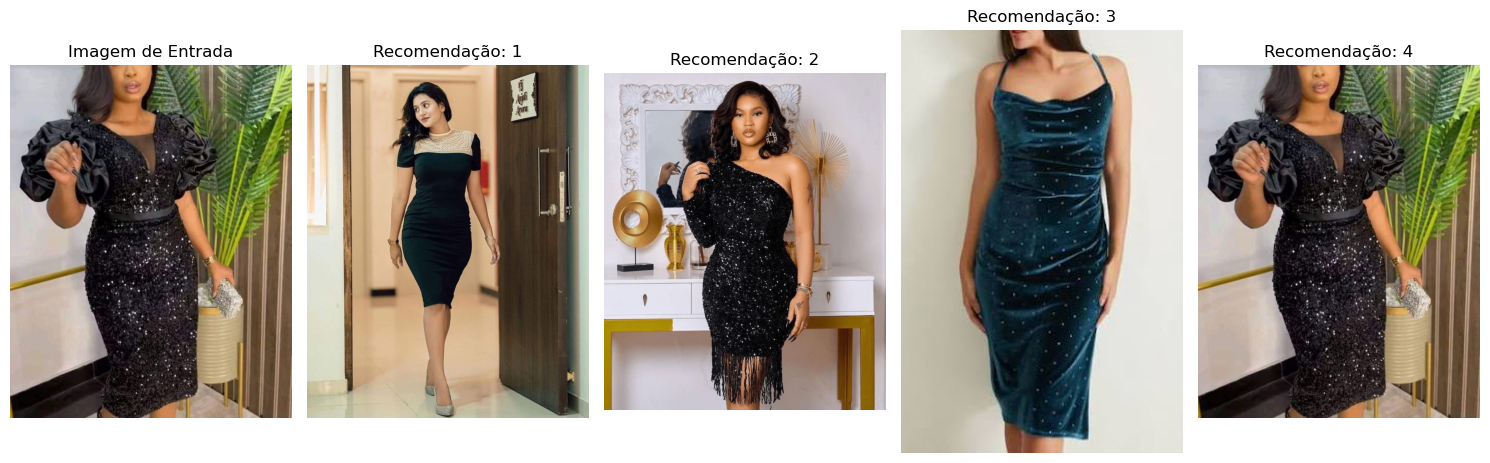

In [87]:
input_image_path = '/media/hccruz/Arquivos/Documentos/PortfolioProjetos/SistemaRecomendacaoModa/women_fashion/women fashion/sparkling black dress.jpg'
recommend_fashion_items_cnn(input_image_path, all_features, lista_caminho_imagem, modelo, top_n=4)